# RBA Selected Tables

<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Set-Up" data-toc-modified-id="Set-Up-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Set-Up</a></span><ul class="toc-item"><li><span><a href="#Some-useful-constants" data-toc-modified-id="Some-useful-constants-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Some useful constants</a></span></li><li><span><a href="#List-available-data-tables---but-only-if-needed" data-toc-modified-id="List-available-data-tables---but-only-if-needed-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>List available data tables - but only if needed</a></span></li><li><span><a href="#Clear-cache---but-only-if-necessary" data-toc-modified-id="Clear-cache---but-only-if-necessary-1.3"><span class="toc-item-num">1.3&nbsp;&nbsp;</span>Clear cache - but only if necessary</a></span></li><li><span><a href="#Utility-functions" data-toc-modified-id="Utility-functions-1.4"><span class="toc-item-num">1.4&nbsp;&nbsp;</span>Utility functions</a></span></li></ul></li><li><span><a href="#Monetary-Policy---Official-Cash-Rate-(A2)" data-toc-modified-id="Monetary-Policy---Official-Cash-Rate-(A2)-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Monetary Policy - Official Cash Rate (A2)</a></span><ul class="toc-item"><li><span><a href="#Anticipate-a-rate-rise-and-highlight-the-rising-cycles" data-toc-modified-id="Anticipate-a-rate-rise-and-highlight-the-rising-cycles-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Anticipate a rate rise and highlight the rising cycles</a></span></li></ul></li><li><span><a href="#Key-market-interest-rates-(F1)" data-toc-modified-id="Key-market-interest-rates-(F1)-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Key market interest rates (F1)</a></span></li><li><span><a href="#Australian-Government-Bonds---daily-rates-(F2)" data-toc-modified-id="Australian-Government-Bonds---daily-rates-(F2)-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Australian Government Bonds - daily rates (F2)</a></span></li><li><span><a href="#Growth-in-credit-aggregates-(D1)" data-toc-modified-id="Growth-in-credit-aggregates-(D1)-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Growth in credit aggregates (D1)</a></span></li><li><span><a href="#Money-supply-and-the-velocity-of-money-(D3)" data-toc-modified-id="Money-supply-and-the-velocity-of-money-(D3)-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Money supply and the velocity of money (D3)</a></span><ul class="toc-item"><li><span><a href="#Money-supply" data-toc-modified-id="Money-supply-6.1"><span class="toc-item-num">6.1&nbsp;&nbsp;</span>Money supply</a></span></li><li><span><a href="#Nominal-GDP" data-toc-modified-id="Nominal-GDP-6.2"><span class="toc-item-num">6.2&nbsp;&nbsp;</span>Nominal GDP</a></span></li><li><span><a href="#Velocity-of-money" data-toc-modified-id="Velocity-of-money-6.3"><span class="toc-item-num">6.3&nbsp;&nbsp;</span>Velocity of money</a></span></li></ul></li><li><span><a href="#Watermark" data-toc-modified-id="Watermark-7"><span class="toc-item-num">7&nbsp;&nbsp;</span>Watermark</a></span></li></ul></div>

## Set-Up

In [1]:
# usual data science imports
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patheffects as pe

# system imports
from pathlib import Path

# local imports
import rba_common
from abs_common import (
    get_ABS_meta_and_data,
    get_fs_constants,
    recalibrate_series,
)

from finalise_plot import finalise_plot

### Some useful constants

In [2]:
TODAY = pd.Timestamp('today')
TOMORROW = TODAY + pd.DateOffset(days=1)

# multi-time-period charts
RECENCY_PERIOD = 5 # years
RECENT = TODAY - pd.DateOffset(years=RECENCY_PERIOD)

V_RECENCY_PERIOD = 300 # days
V_RECENT = TODAY - pd.DateOffset(days=V_RECENCY_PERIOD)

TEN_YEARS = TODAY - pd.DateOffset(years=10)

# Where to put the charts
CHART_DIR = "./charts/RBA"
Path(CHART_DIR).mkdir(parents=True, exist_ok=True)

# plotting stuff
plt.style.use('fivethirtyeight')
SOURCE = "Source: RBA"

### List available data tables - but only if needed

In [3]:
if False: 
    rba_common.get_data_table_labels()

### Clear cache - but only if necessary

In [4]:
if False:
    rba_common.clear_cache()

### Utility functions

In [5]:
def print_last_date(df: pd.DataFrame) -> None:
    print('Last date', df.index[-1].date())
    
def print_last_row(df: pd.DataFrame) -> None:
    print('Last date', df.loc[df.index[-1]])

## Monetary Policy - Official Cash Rate (A2)

In [6]:
# get the data
a2 = rba_common.get_data('Monetary Policy Changes – A2')
a2_meta, a2_data = a2 if a2 is not None else (None, None)
print_last_date(a2_data)

Using cached data for "Monetary Policy Changes – A2"
Last date 2022-12-07


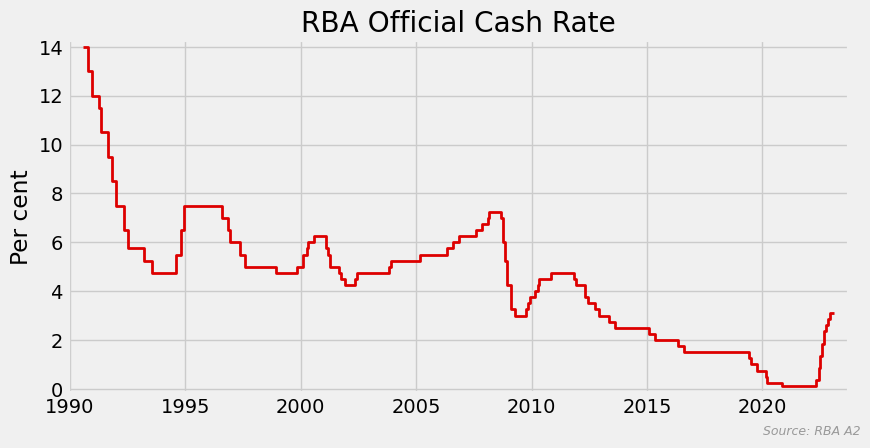

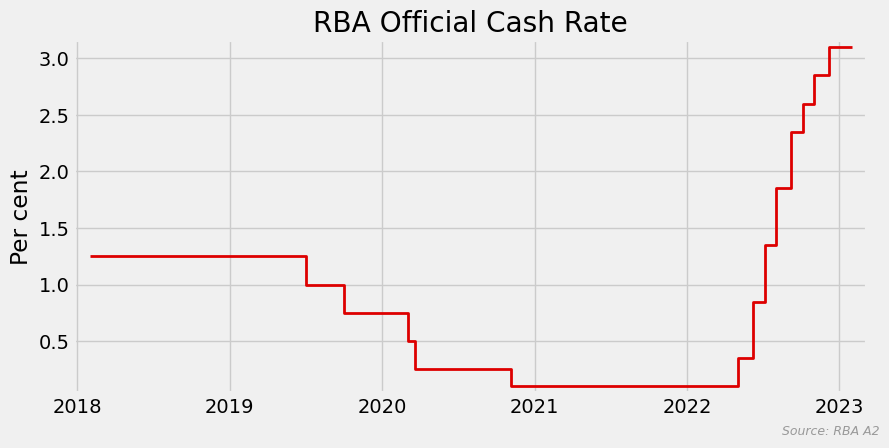

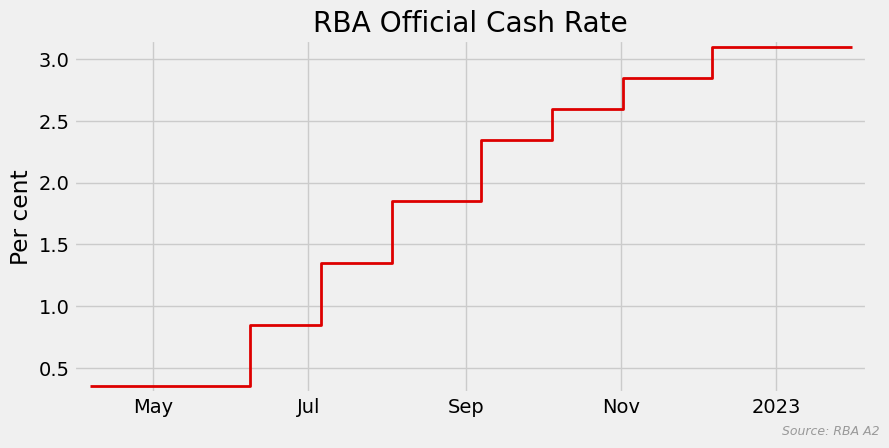

In [7]:
# extract the cash rate series
target = 'New Cash Rate Target'
series_id = a2_meta[a2_meta.Title == target].index[0]
series = a2_data[series_id]

# remove some early target ranges
series = series[series.index >= pd.Timestamp("1990-08-02")].astype(float)

# update the series to today
if TODAY > series.index[-1]:
    last = series.iloc[-1]
    series[TODAY] = last
    series = series.sort_index()
                        
# plot full series and recent
count=0
for start in None, RECENT, V_RECENT:
    # get data and filename-tag
    data = series if start is None else series[series.index >= start].copy()
    tag = "" if start is None else f'-recent{count}'
    if start is not None and start < data.index[0]:
        data[start] = data.iloc[0]
        data = data.sort_index()
    count += 1
        
    # plot
    ax = data.plot(drawstyle='steps-post', c='#dd0000', lw=2)
    ax.margins(0.025, 0.025)
    title = "RBA Official Cash Rate"
    finalise_plot(
        ax, title, "Per cent", tag, CHART_DIR,
        rfooter=f'{SOURCE} A2',
        concise_dates=True,
        show=True,
    )

### Anticipate a rate rise and highlight the rising cycles

In [8]:
def plot_series_highlighted(series:pd.Series, **kwargs) -> plt.Axes:
    """Plot a series of percentages, highlighting the increasing runs."""
    
    # default arguments
    arg = 'threshhold' # used to manage micro-noise in data
    threshold = 0 if arg not in kwargs or kwargs[arg] is None else kwargs[arg]
    arg = 'round'
    round = 2 if arg not in kwargs or kwargs[arg] is None else kwargs[arg]

    # identify the runs
    diffed = series.diff()
    up = diffed[diffed.gt(threshold)]
    down = diffed[diffed.lt(-threshold)]
    change_points = pd.concat([up, down]).sort_index()
    if series.index[0] not in change_points.index:
        starting_point = pd.Series([0], index=[series.index[0] ])
        change_points = pd.concat([change_points, starting_point]).sort_index()
    rising = (change_points > 0)
    cycles = (rising & ~rising.shift().astype(bool)).cumsum()
    rising_stretches = cycles[rising]

    # chart
    ax = series.plot(drawstyle='steps-post', lw=2, c='#dd0000')

    mid_range = (series.max() + series.min()) / 2
    for k in range(1, rising_stretches.max() + 1):
        stretch = rising_stretches[rising_stretches == k]
        increase = change_points[stretch.index].sum().round(round).astype(str) + ' pp'

        start = stretch.index.min()
        stop = stretch.index.max()
        ax.axvspan(start, stop, color='gold', zorder=-1)
        increase = change_points[stretch.index].sum().round(2).astype(str) + ' pp'
        if series[stretch.index].min() < mid_range:
            y, va = series.max(), 'top'
        else:
            y, va = series.min(), 'bottom'
        text = ax.text(x=start, y=y, s=increase, rotation=90, va=va, ha='left')
        text.set_path_effects([pe.withStroke(linewidth=5, foreground='w')])

    return ax

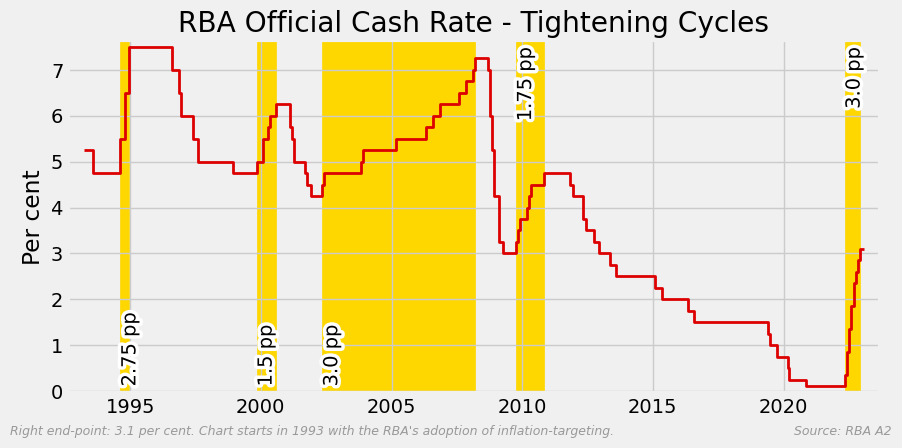

In [9]:
ANTICIPATE, BY = False, 0.25 # useful for chart before rate rise in RBA data-stream
augmented = series.copy()

if ANTICIPATE:
    increase = pd.Series([series[-1] + BY], index=[TOMORROW])
    augmented = pd.concat([series, increase]).sort_index()
    
from_date = '1993-01-01' # Start of RBA inflation-targeting approach
augmented = augmented[augmented.index >= from_date]
augmented.index = augmented.index.to_period(freq='D')

ax = plot_series_highlighted(augmented)

finalise_plot(
    ax, 
    'RBA Official Cash Rate - Tightening Cycles', 
    'Per cent', 
    '', CHART_DIR,
    rfooter=f'{SOURCE} A2',
    lfooter=f'Right end-point: {augmented[-1]} per cent. '
            "Chart starts in 1993 with the RBA's adoption of inflation-targeting. ",
    show=True,
)

## Key market interest rates (F1)

In [10]:
# get the dataset
_ = rba_common.get_data('Interest Rates and Yields – Money Market – Daily – F1')
f1_meta, f1_data = _ if _ is not None else (None, None)

# just to see data currency ...
f1_data.loc[f1_data.index[-3:]] 

Cache data not stored in cache for "Interest Rates and Yields – Money Market – Daily – F1"


Series ID,FIRMMCRTD,FIRMMCCRT,FIRMMCRID,FIRMMCRIH,FIRMMCRIL,FIRMMCRIV,FIRMMCRIN,FIRMMCTRI,FIRMMBAB30D,FIRMMBAB90D,FIRMMBAB180D,FIRMMOIS1D,FIRMMOIS3D,FIRMMOIS6D,FIRMMTN1D,FIRMMTN3D,FIRMMTN6D
F1 INTEREST RATES AND YIELDS – MONEY MARKET,,,,,,,,,,,,,,,,,
2023-01-25,3.1,NaN,3.07,3.07,3.07,320,4,126.2663,3.325,3.4607,3.7583,NaN,NaN,NaN,NaN,NaN,NaN
2023-01-27,3.1,NaN,3.07,3.07,3.07,425,3,126.28754,3.1687,3.3921,3.745,NaN,NaN,NaN,NaN,NaN,NaN
2023-01-30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,126.319406,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


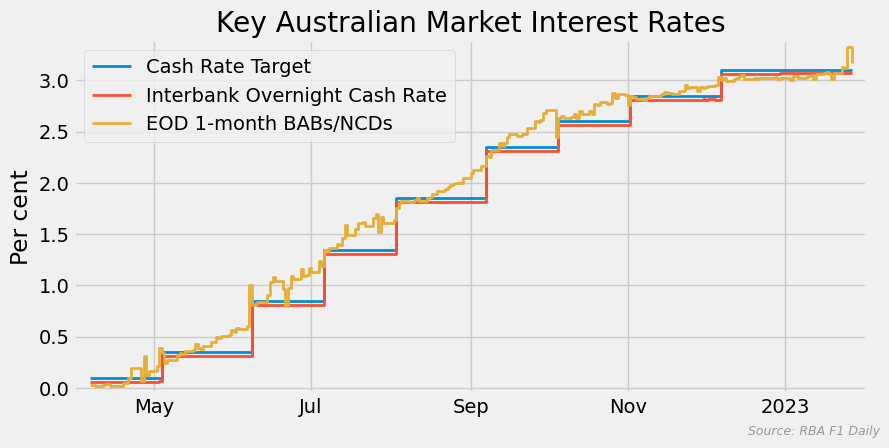

In [11]:
# get the specific data we want, for the very recent past
wanted = ['Cash Rate Target',
          'Interbank Overnight Cash Rate',
          'EOD 1-month BABs/NCDs',
          #'1-month OIS', # discontinued December 2022
          '1-month Treasury Note',]
series_ids = [f1_meta[f1_meta.Title == x].index[0] for x in wanted]
plotable_data = (
    f1_data[series_ids]
    .pipe(lambda x: x[x.index>=V_RECENT])
    .rename({old:neu for old, neu in zip(series_ids, wanted)}, axis=1)
    .dropna(how='all', axis=1)
    .dropna(how='all', axis=0)
    .ffill()
)

# And plot
ax = plotable_data.plot(drawstyle='steps-post', lw=2)
ax.margins(0.025, 0.025)
title = "Key Australian Market Interest Rates"
ax.legend(title=None, loc='best')

finalise_plot(
    ax, title, "Per cent", "", CHART_DIR,
    rfooter=f'{SOURCE} F1 Daily',
    concise_dates=True,
    show=True,
)

## Australian Government Bonds - daily rates (F2)

In [12]:
# get the dataset
_ = rba_common.get_data('Capital Market Yields – Government Bonds – Daily – F2')
f2_meta, f2_data = _ if _ is not None else (None, None)
f2_data.loc[f2_data.index[-3:]] # just to see data currency

Cache data not stored in cache for "Capital Market Yields – Government Bonds – Daily – F2"


Series ID,FCMYGBAG2D,FCMYGBAG3D,FCMYGBAG5D,FCMYGBAG10D,FCMYGBAGID,FCMYGBNT3D,FCMYGBNT5D,FCMYGBNT10D
F2 CAPITAL MARKET YIELDS – GOVERNMENT BONDS,,,,,,,,
2023-01-25,3.105,3.13,3.22,3.505,1.33,3.55,3.695,4.245
2023-01-27,3.17,3.2,3.29,3.555,1.37,3.615,3.755,4.29
2023-01-30,3.145,3.175,3.275,3.53,1.35,3.595,3.74,4.275


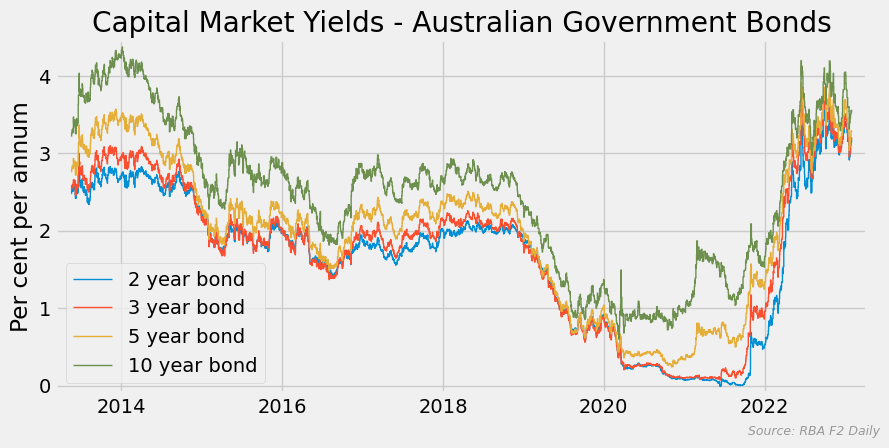

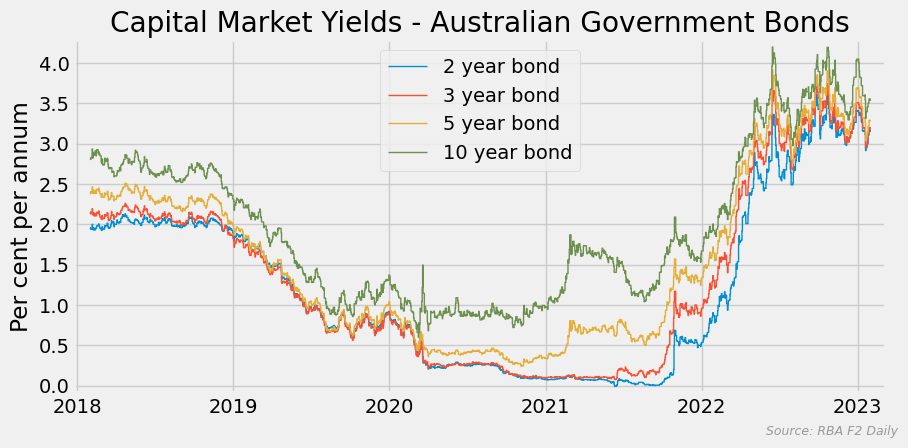

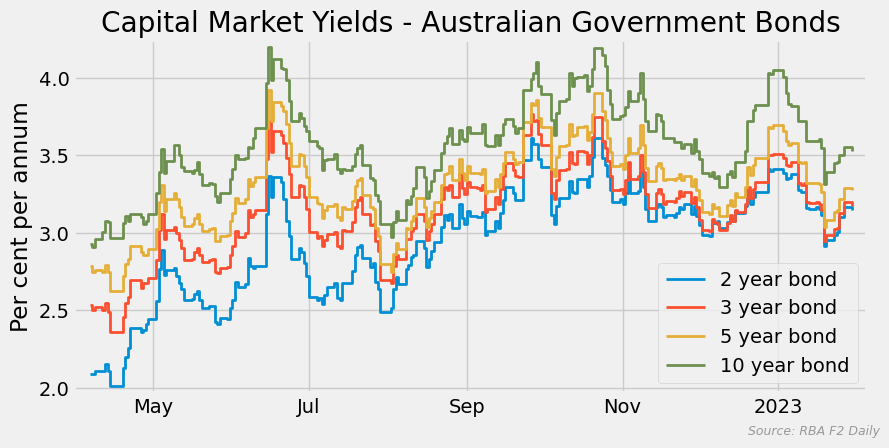

In [13]:
# get the specific data we want
plotable = f2_meta[f2_meta.Title.str.contains('Australian') &
                   f2_meta.Title.str.contains('year') ]
plotable_labels = (
    plotable
    .Title
    .str.replace('Australian Government ', '')
)
plotable_data = f2_data[plotable_labels.index]
plotable_data.columns = plotable_labels

# plot full series and recent
count = 0
for start in None, RECENT, V_RECENT:
    # get data and filename-tag
    data = plotable_data if start is None else plotable_data[plotable_data.index >= start].copy()
    tag = "" if start is None else f'-recent{count}'
    lw = 2 if start == V_RECENT else 1
    count += 1
        
    # plot
    ax = data.plot(drawstyle='steps-post', lw=lw)
    ax.margins(0.025, 0.025)
    title = "Capital Market Yields - Australian Government Bonds"
    
    # remove legend title
    #handles, labels = ax.get_legend_handles_labels()
    ax.legend(title=None, loc='best')
    
    # finalise
    finalise_plot(
        ax, title, "Per cent per annum", tag, CHART_DIR,
        rfooter=f'{SOURCE} F2 Daily',
        concise_dates=True,
        show=True,
    )    

## Growth in credit aggregates (D1)

In [14]:
data_label = 'Growth in Selected Financial Aggregates – D1'
_ = rba_common.get_data(data_label)
d1_meta, d1_data = _ if _ is not None else (None, None)
print_last_date(d1_data)

Cache data not stored in cache for "Growth in Selected Financial Aggregates – D1"
Last date 2022-11-30


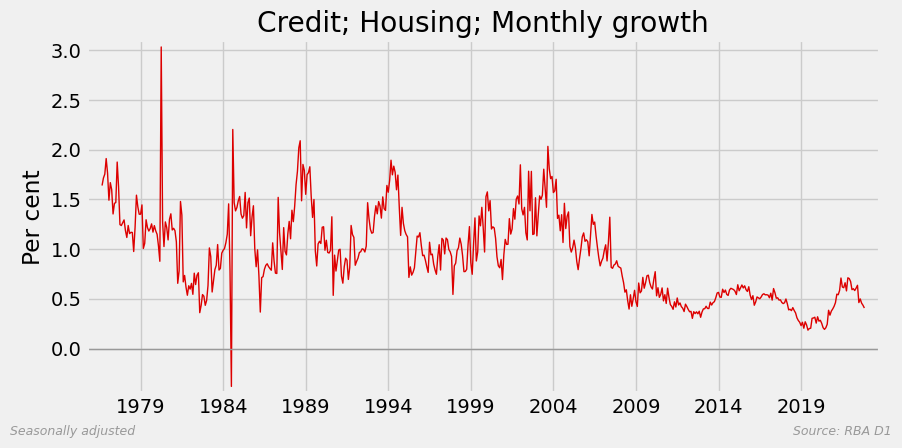

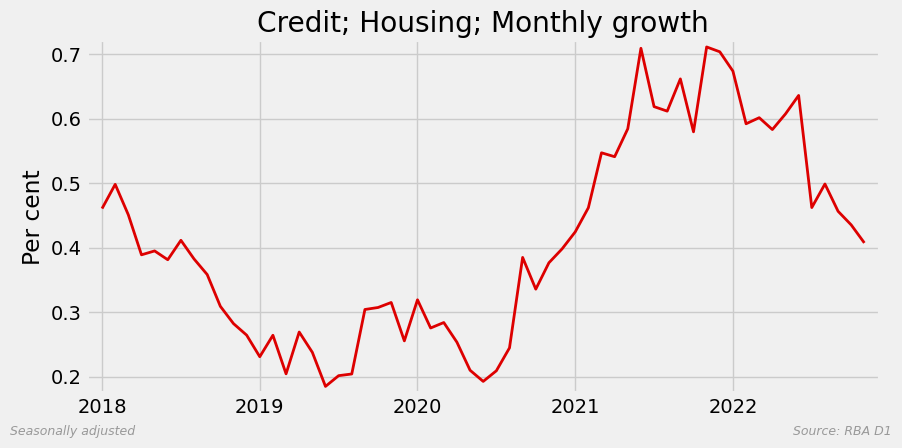

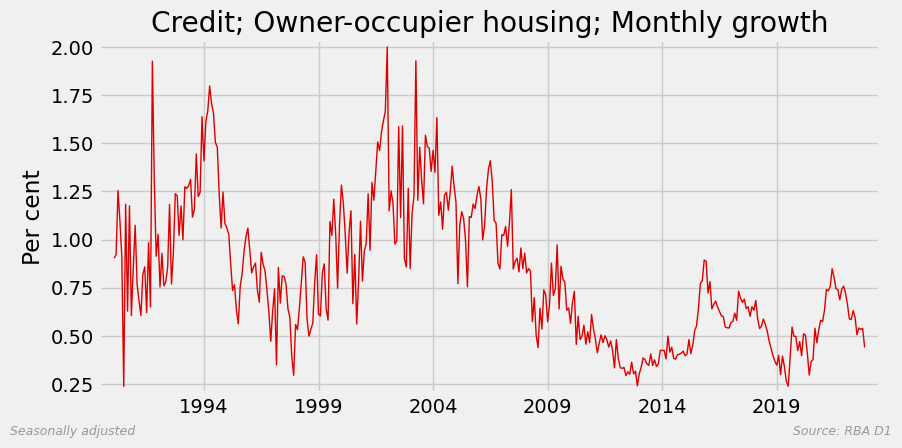

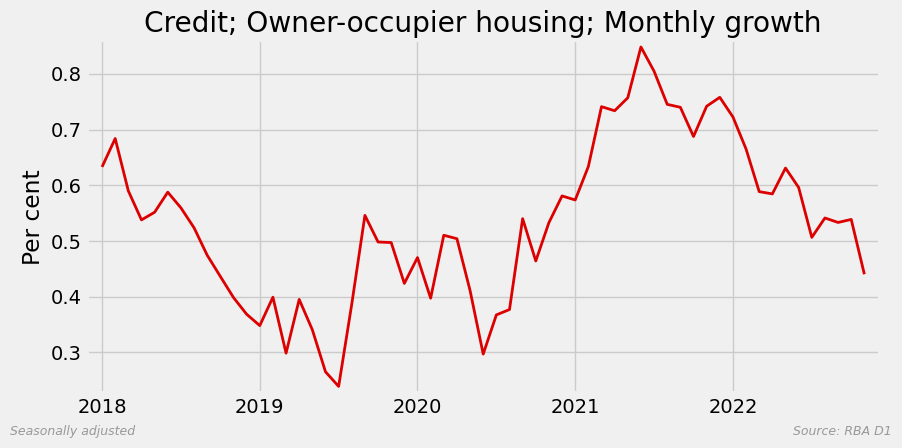

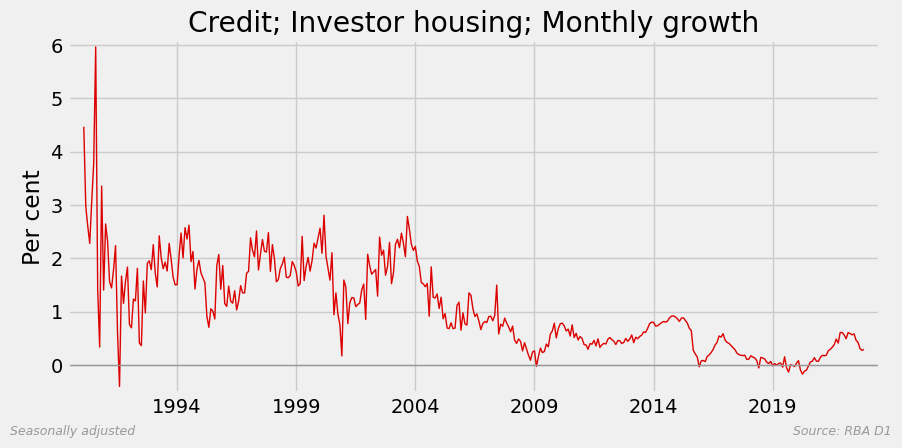

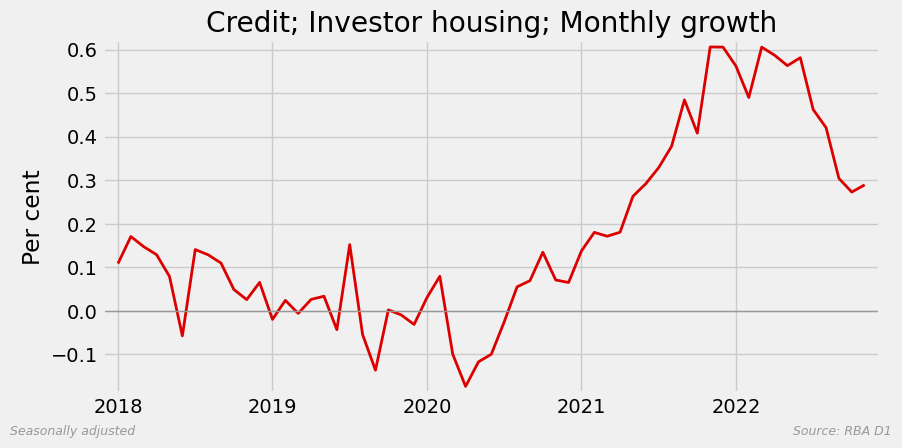

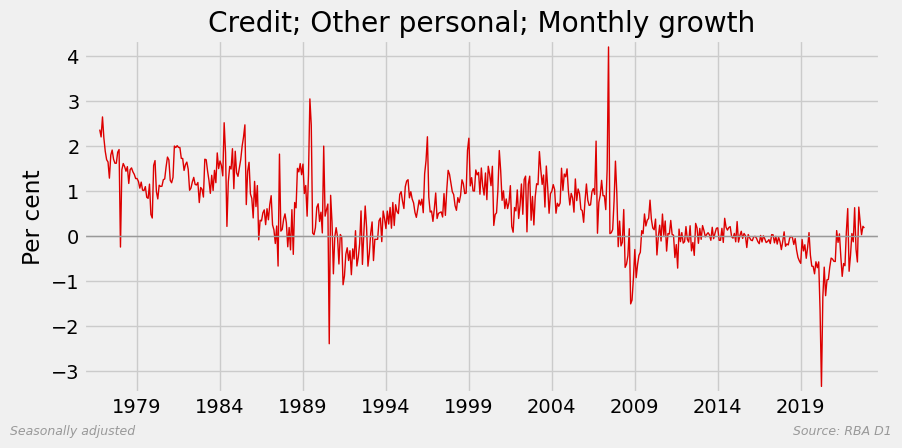

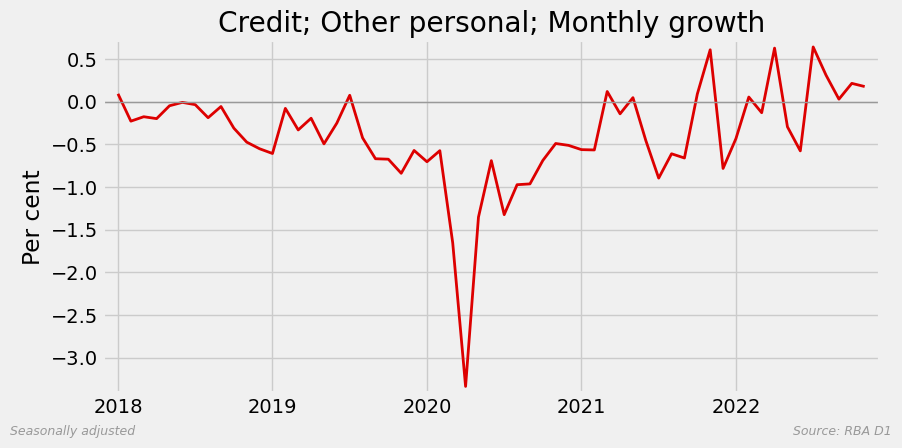

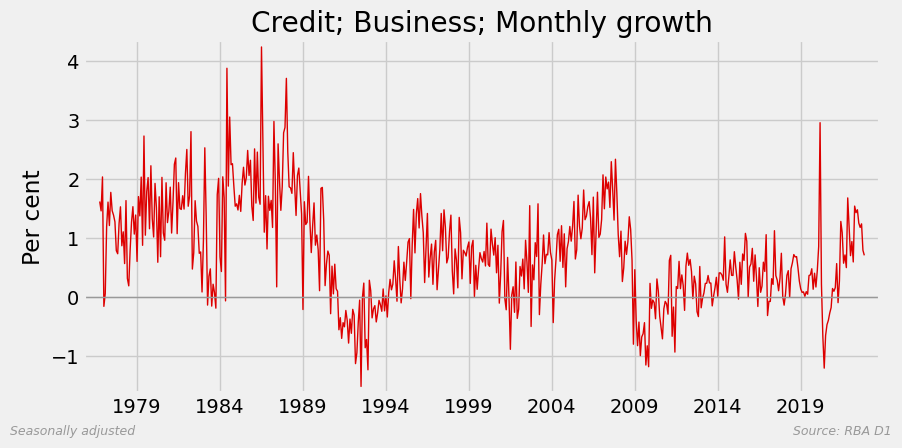

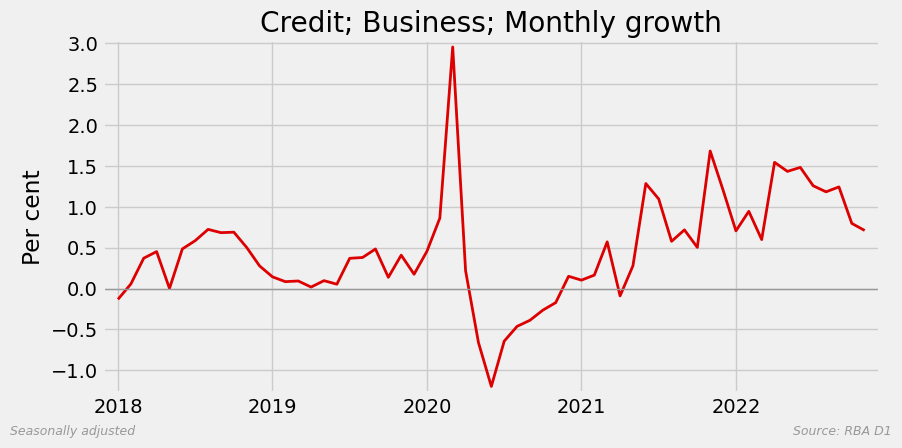

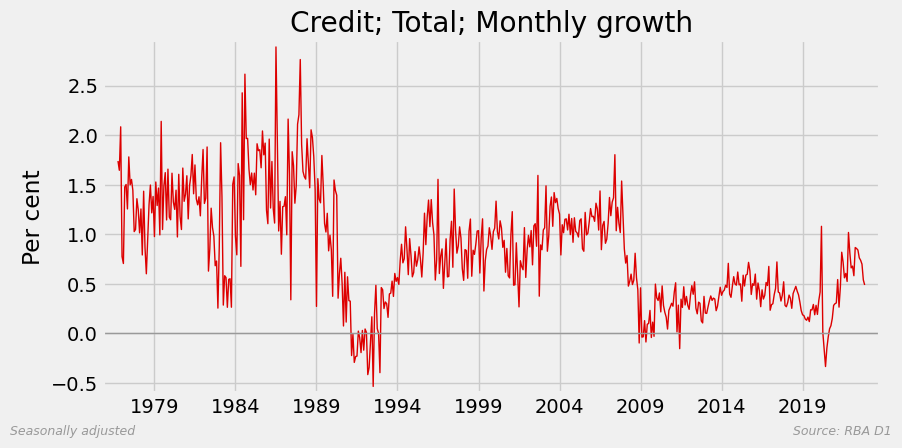

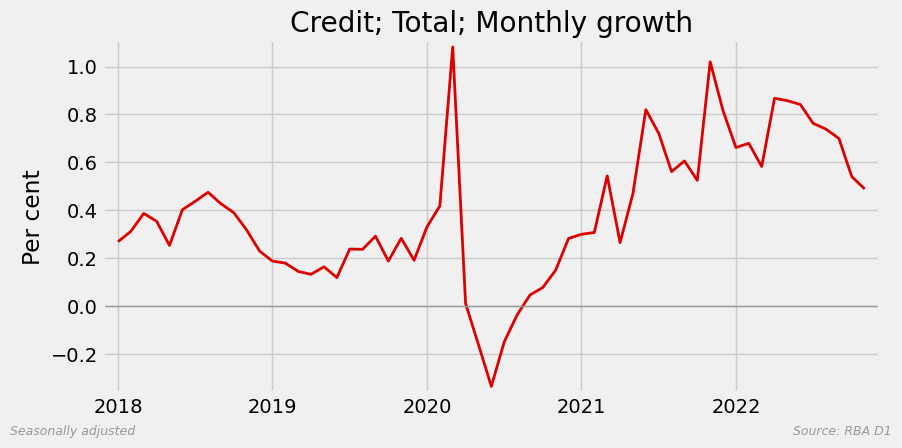

In [15]:
chart_set = [
    'Credit; Housing; Monthly growth',
    'Credit; Owner-occupier housing; Monthly growth',
    'Credit; Investor housing; Monthly growth',
    'Credit; Other personal; Monthly growth',
    'Credit; Business; Monthly growth',
    'Credit; Total; Monthly growth',
]

for label in chart_set:
    name = d1_meta[d1_meta.Title == label].index[0]
    type = d1_meta[d1_meta.Title == label].Type.iloc[0]
    series = d1_data[name]
    
    for start in None, RECENT:
        data = series if start is None else series[series.index >= start].copy()
        tag = "" if start is None else '-recent'
        lw = 2 if start else 1
        ax = data.plot(lw=lw, c='#dd0000')
        
        if data.min() < 0 and data.max() > 0:
            ax.axhline(lw=1, c='#999999')

        finalise_plot(
            ax, label, "Per cent", tag, CHART_DIR,
            rfooter=f'{SOURCE} D1',
            lfooter=type,
            show=True,
        )    

## Money supply and the velocity of money (D3)

According to the Quantity Theory of Money:

$$ MV=PT $$

Where ($M$) is money supply, ($V$) is the velocity of circulation (the number of times 
money changes hands), ($P$) is the average price level, and ($T$) is the volume of transactions of goods and services. Of note: $PT$ is the same as nominal GDP. Therefore:

$$V=\frac{nGDP}{M}$$


### Money supply

In [16]:
# Get DataFrame for the M1 and M3 money supply
_ = rba_common.get_data('Monetary Aggregates – D3')
d3_meta, d3_data = _ if _ is not None else (None, None)
print_last_date(d3_data)

Cache data not stored in cache for "Monetary Aggregates – D3"
Last date 2022-11-30


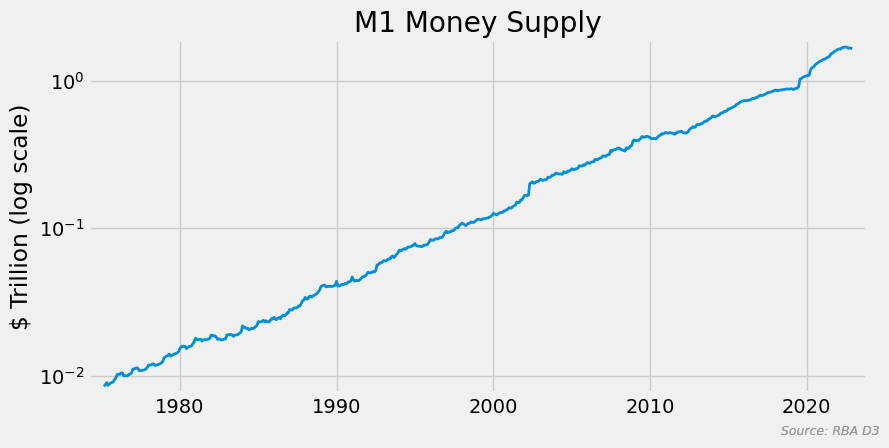

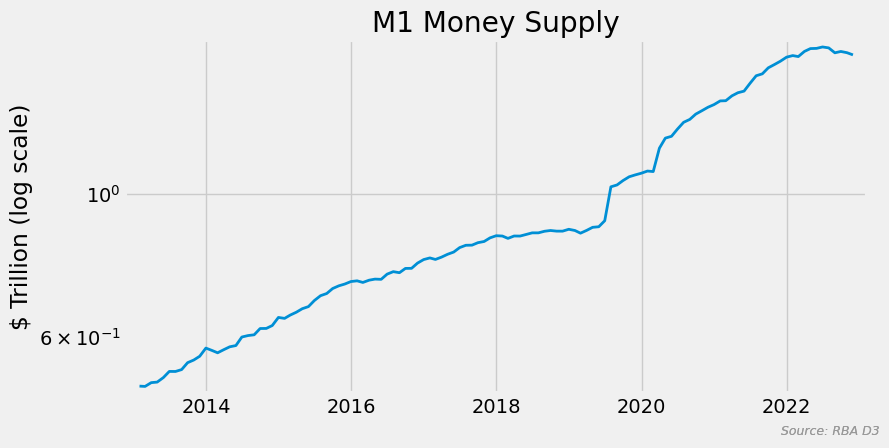

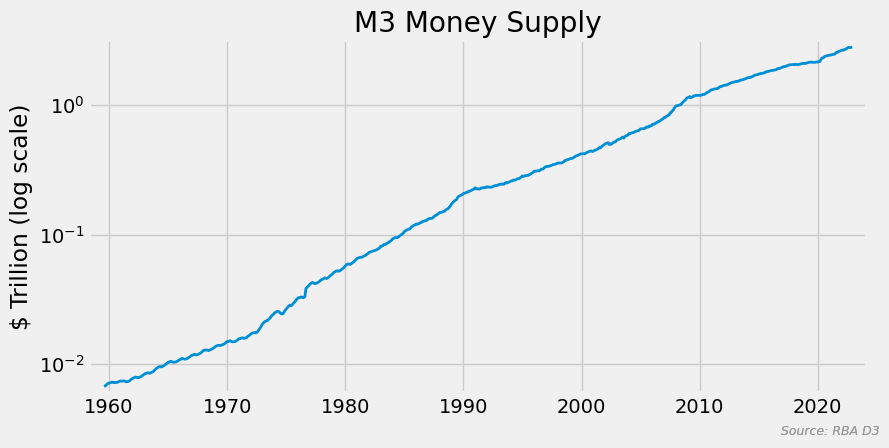

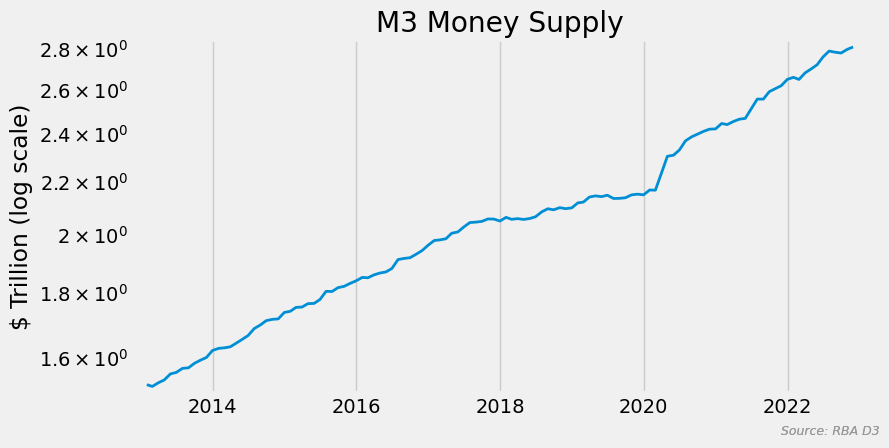

In [17]:
# plot Money Supply
to_get = ['M1', 'M3']
gotten = {t:d3_data[d3_meta[d3_meta.Title == t].index[0]] for t in to_get}
m_units = {t:d3_meta[d3_meta['Title'] == t].Units[0] for t in to_get}

for title, series in gotten.items():
    series = series.dropna().astype(float)
    series, m_unit = recalibrate_series(series, m_units[title])
    
    for start in None, TEN_YEARS:
        plotable = series if start is None else series[series.index >= start]
        tag = "" if start is None else f'recent'
        
        fig, ax = plt.subplots()
        ax.plot(plotable.index, plotable, lw=2)
        finalise_plot(
            ax, f'{title} Money Supply', m_unit, tag, CHART_DIR,
            rfooter=f'{SOURCE} D3',
            concise_dates=True,
            dont_close=True,
            #show=True,
        )

        ax.set_yscale('log')
        finalise_plot(
            ax, f'{title} Money Supply', 
            f'{m_unit} (log scale)', f'{tag}-log', CHART_DIR,
            rfooter=f'{SOURCE} D3',
            concise_dates=True,
            show=True,
        )
        
        # Note: matplotlib will only let you show either 
        #       the linear or log charts, but not both.

### Nominal GDP

In [18]:
# get nominal GDP from the ABS National Accounts
catalogue_id = '5206'
abs_dict = get_ABS_meta_and_data(catalogue_id)
source, _, META_DATA = get_fs_constants(catalogue_id)
meta = abs_dict[META_DATA]

table = '3' # GDP expenditure in current prices
data = abs_dict[table]

series_type = 'Seasonally Adjusted'
data_item = 'GROSS DOMESTIC PRODUCT ;'
selected = meta[
    (meta.Table == table)
    & (meta['Series Type'] == series_type)
    & meta['Data Item Description'].str.contains(data_item)
]
assert len(selected) == 1
units = selected.Unit.iloc[0]
series_id = selected['Series ID'].iloc[0]
yearly_nom_gdp = data[series_id].rolling(4).sum().dropna() # sum to annual nominal GDP
yearly_nom_gdp, units = recalibrate_series(yearly_nom_gdp, units)


Found URL for a ZIP file on ABS web page
We need to download this file from the ABS ...
Saving ABS download to cache.
Extracting DataFrames from the zip-file ...


### Velocity of money

In [19]:
# still to do

## Watermark

In [20]:
%load_ext watermark
%watermark -u -n -t -v -iv -w

Last updated: Mon Jan 30 2023 22:00:49

Python implementation: CPython
Python version       : 3.10.8
IPython version      : 8.7.0

matplotlib: 3.6.3
pandas    : 1.5.3

Watermark: 2.3.1

